# Assignment 2  - Classification
### Due Date: 3 April 11.59pm (or 6 April 11.59pm if late period is used)
### Your Name Here (Your NUSNET ID Here)
Sentences in <span style="color:blue">blue</span> indicate questions to be answered. 

If you wish to type math equations in markdown, follow this link: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

Please save this Jupyter notebook as __YourNameInLumiNUS_YourNUSNETID.ipynb__.

If you have further questions, you can post on the LumiNUS forums, or email Wenjie Wang (e0409768@u.nus.edu) or the lecturer, Bryan Hooi (bhooi@comp.nus.edu.sg).

### Introduction
In this assignment, you are a data scientist at the Pima Womans Hospital of Arizona. You have been asked by the hospital to develop a computer program that can accurately diagnose whether a patient has diabetes. You are provided with a dataset containing historical records of measurements and outcomes. You will be using some common data mining libraries to achieve your objective. Detailed instructions and questions are given in the following sections.

### Dataset
The Pima Indians of Arizona have the highest rate of obesity and diabetes ever recorded. This dataset was collected by the National Institute of Diabetes and Digestive and Kidney Diseases, with the objective to predict whether or not a patient has diabetes based on certain diagnostic measurements. All the patients recorded in this dataset are females of the Pima Indian heritage. The dataset consists of 8 medical predictor variables and one target variable, Outcome. Table 1 shows the description of each variable. Your task is to build classiﬁcation models for predicting Outcome based on the other variables.


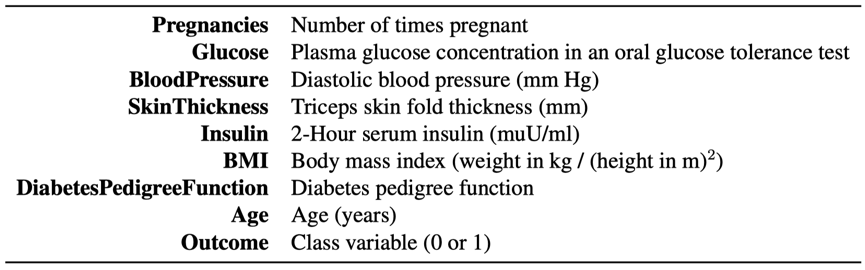

**----- Import all libraries here -----**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning and Analysis (10 points)

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [2]:
# --- Your code here ---
pima = pd.read_csv("diabetes.csv")
for column, data_type in zip(pima.columns, pima.dtypes):
    print(column, data_type)

Pregnancies int64
Glucose int64
BloodPressure float64
SkinThickness float64
Insulin int64
BMI float64
DiabetesPedigreeFunction float64
Age int64
Outcome int64


<span style="color:blue">2) Are there any missing values in the dataset? For each attribute in the dataset, print out the total number of missing values in the dataset for that attribute. How would you handle the missing values without deleting any record?*(3 points)*
<br/>
_(Hint: you can use the **fillna** function to replace them with the means of the corresponding columns if there are only a few missing values.)_
</span>

In [3]:
# --- Your code here ---
print('Before replacing missing values: ')
for column in pima.columns:
    missing_values = pd.isna(pima[column]).sum()
    print(column," has ",missing_values," missing values")

# operation
pima = pima.fillna(pima.mean())
print('\nAfter replacing missing values: ')
for column, mean_value in zip(pima.columns, pima.mean()):
    missing_values = pd.isna(pima[column]).sum()
    print(column," has ",missing_values," missing values, mean value is ",mean_value)

Before replacing missing values: 
Pregnancies  has  0  missing values
Glucose  has  0  missing values
BloodPressure  has  1  missing values
SkinThickness  has  1  missing values
Insulin  has  0  missing values
BMI  has  0  missing values
DiabetesPedigreeFunction  has  1  missing values
Age  has  0  missing values
Outcome  has  0  missing values

After replacing missing values: 
Pregnancies  has  0  missing values, mean value is  3.8450520833333335
Glucose  has  0  missing values, mean value is  120.89453125
BloodPressure  has  0  missing values, mean value is  69.11994784876141
SkinThickness  has  0  missing values, mean value is  20.52411994784876
Insulin  has  0  missing values, mean value is  79.79947916666667
BMI  has  0  missing values, mean value is  31.992578124999977
DiabetesPedigreeFunction  has  0  missing values, mean value is  0.4715814863102992
Age  has  0  missing values, mean value is  33.240885416666664
Outcome  has  0  missing values, mean value is  0.3489583333333333


<span style="color:blue">3) Show the count of “0”s and “1”s in *Outcome* using a bar graph. Write down what you observe in the bar plot. How does this observation affect what metrics you would use to evaluate a classifier for predicting *Outcome*?*(5 points)*
<br/>_(Hint: you can draw the bar plot with the help of **sb.countplot**.)_
</span>

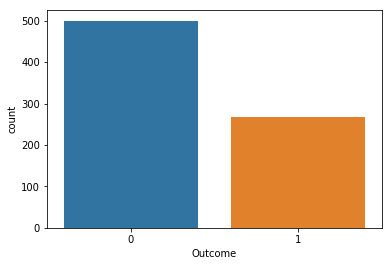

In [4]:
# --- Your code here ---
outcomes = pima["Outcome"]
sb.countplot(x="Outcome",data=pima)

<span style="color:blue">--- Your answer here ---</span>
We can see that the number of "0" is roughly twice that of "1".

So if the classifier is good, it will have more TF than TP. The data is not very balanced.So I will emphasize on **recall** and **precision**, and their combination -- **F-measure**. These metrics will minimize the effect of TF, which will help tell the classifier's ability to recoginize "1".

## 2. Feature Transformation (20 points)

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature Set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *BMI* or *BloodPressure*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. Cut the continuous values of each feature into non-overlapping buckets: for Glucose, adopt the glucose level guidelines given by American Diabetes Association:<br/>*
*- Normal: < 140mg/dl of glucose,<br/>*
*- Prediabetes: 140-199mg/dl of glucose,<br/>*
*- Diabetes: > 200mg/dl of glucose<br/>*
To do this, you can use **pd.cut** with bins of **[50,139.99,199.99,250]** and labels of **['Normal', 'Prediabetes', 'Diabetes']**. For the other variables, cut them based on quantiles into 3 buckets each. To do this, you can use **pd.qcut** with 3 quantiles, with **duplicates='drop'**. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 column with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(8 points)*</span>
    

In [5]:
# --- Your code here ---
pima1 = pd.DataFrame()
pima1["Glucose"] = pd.cut(pima["Glucose"],bins=[50,139.99,199.99,250],labels=['Normal', 'Prediabetes', 'Diabetes'])
for column in pima.columns:
    if column == "Glucose" or column == "Outcome":
        continue
    pima1[column] = pd.qcut(pima[column],3, duplicates="drop")
pima1["Outcome"] = pima["Outcome"]
# --- End of your code ---

print(pima1.shape)
pima1.head()

(768, 9)


,Glucose,Pregnancies,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,Prediabetes,"(5.0, 17.0]","(66.0, 76.0]","(30.0, 99.0]","(-0.001, 94.333]","(28.9, 34.733]","(0.528, 2.42]","(36.0, 81.0]",1
1,Normal,"(-0.001, 2.0]","(-0.001, 66.0]","(13.0, 30.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.268, 0.528]","(25.0, 36.0]",0
2,Prediabetes,"(5.0, 17.0]","(-0.001, 66.0]","(-0.001, 13.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.528, 2.42]","(25.0, 36.0]",1
3,Normal,"(-0.001, 2.0]","(-0.001, 66.0]","(13.0, 30.0]","(-0.001, 94.333]","(-0.001, 28.9]","(0.077, 0.268]","(20.999, 25.0]",0
4,Normal,"(-0.001, 2.0]","(-0.001, 66.0]","(30.0, 99.0]","(94.333, 846.0]","(34.733, 67.1]","(0.528, 2.42]","(25.0, 36.0]",1


<span style="color:blue">2) Next, we convert the generated categorical features into binary features using the one-hot encoding scheme: given a categorical feature containing $m$ categories, one-hot encoding will encode each value into a vector of size $m$ with only one of its values as 1 (indicating it as active), and its other values as 0. At the end, **pima1** should have $(m_1+m_2+…+m_8+1)$ columns where $m_i$ denotes the number of categories for variable i, and the 1 is for the Outcome variable. Use **pima1.head()** to show the top rows of the encoded **pima1**. *(4 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each categorical feature in **pima1** into multiple binary features.)*</span>

In [6]:
# --- Your code here ---
pima1 = pd.get_dummies(pima1)
# --- End of your code ---

print(pima1.shape)
pima1.head()

(768, 24)


,Outcome,Glucose_Normal,Glucose_Prediabetes,Glucose_Diabetes,"Pregnancies_(-0.001, 2.0]","Pregnancies_(2.0, 5.0]","Pregnancies_(5.0, 17.0]","BloodPressure_(-0.001, 66.0]","BloodPressure_(66.0, 76.0]","BloodPressure_(76.0, 122.0]",...,"Insulin_(94.333, 846.0]","BMI_(-0.001, 28.9]","BMI_(28.9, 34.733]","BMI_(34.733, 67.1]","DiabetesPedigreeFunction_(0.077, 0.268]","DiabetesPedigreeFunction_(0.268, 0.528]","DiabetesPedigreeFunction_(0.528, 2.42]","Age_(20.999, 25.0]","Age_(25.0, 36.0]","Age_(36.0, 81.0]"
0,1,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,1,0,1,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,1,0
3,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0


**Feature Set 2 - Feature Normalization**

<span style="color:blue">3) For the second feature set, we normalize the values of the original 8 continuous variables in the original dataset (not including *Outcome*). For each variable $x$, we apply the transformation using the formula **$z=(x−\mu)/\sigma$**, where $\mu$ and $\sigma$ are the mean and standard deviation of the variable values. Name the resulting DataFrame as **pima2**, and show the top rows using **pima2.head()**. *(8 points)*</span>

<span style="color:blue">*(Hint: you can use **StandardScaler** from scikit-learn for standardization)*</span>

In [7]:
# --- Your code here ---
scalar = StandardScaler()
scalar.fit(pima.drop(columns="Outcome"))
print(scalar.mean_)
pima2 = scalar.transform(pima.drop(columns="Outcome"))
pima2 = pd.DataFrame(data=pima2, columns=pima.drop(columns="Outcome").columns)
pima2["Outcome"] = pima["Outcome"]
# --- End of your code ---
print(pima2.shape)
pima2.head()

[  3.84505208 120.89453125  69.11994785  20.52411995  79.79947917
  31.99257812   0.47158149  33.24088542]
(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.148924,0.908253,-0.692891,0.204013,0.469525,1.425995,1
1,-0.844885,-1.123396,-0.161329,0.531798,-0.692891,-0.684422,-0.364281,-0.190672,0
2,1.233880,1.943724,-0.264747,-1.287734,-0.692891,-1.103255,0.605472,-0.105584,1
3,-0.844885,-0.998208,-0.161329,0.155343,0.123302,-0.494043,-0.920152,-1.041549,0
4,-1.141852,0.504055,-1.505759,0.908253,0.765836,1.409746,5.487468,-0.020496,1


## 3. Model Construction (30 points)

Your task in this section is to use the derived feature sets from the previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have split the data into training and test sets for you as shown below (you need to run the cell below): e.g. x_train1 and y_train1 are the training features and labels for **pima1**.

In [8]:
# pima1 split
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(768, 23) (768,)
(768, 8) (768,)


##### <span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn (directly using the scikit-learn functions imported with their default hyperparameter settings on **pima1** and **pima2** (You should thus perform 5x2 times model training and evaluation):<br/></span>

<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
<span style="color:blue">- random forest<br/></span>
<span style="color:blue">- gradient boosting machine<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(13 points)*</span>

In [9]:
# K-nearest neighbors, Logistic regression, Decision trees, Random forest, Gradient boosting machine
model_names = ['KNN', 'LR', 'DT', 'RF', 'GBM'] 
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
def process_model_data(clf, data_mode):
    if data_mode == 1:
        x_train, y_train, x_test, y_test = x_train1, y_train1, x_test1, y_test1
    elif data_mode == 2:
        x_train, y_train, x_test, y_test = x_train2, y_train2, x_test2, y_test2
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test) 
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    return acc, f1

# 1. KNN
# 1.1 for pami1
clf_knn = KNeighborsClassifier()
acc, f1 = process_model_data(clf_knn, 1)
pima1_acc.append(acc)
pima1_f1.append(f1)
print("knn for pima1 accuracy:",acc,", f1:",f1)
# 1.2 for pami2
acc, f1 = process_model_data(clf_knn, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)
print("knn for pima2 accuracy:",acc,", f1:",f1)

# 2. logistic regression
# 2.1 LR for pami1
clf_LR = LogisticRegression()
acc, f1 = process_model_data(clf_LR, 1)
pima1_acc.append(acc)
pima1_f1.append(f1)
print("Logistic Regression for pima1 accuracy:",acc,", f1:",f1)
# 2.2 LR for pami2
acc, f1 = process_model_data(clf_LR, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)
print("Logistic Regression for pima2 accuracy:",acc,", f1:",f1)

# 3. DecisionTree
# 3.1 DecisionTree for pami1
clf_DT = DecisionTreeClassifier()
acc, f1 = process_model_data(clf_DT, 1)
pima1_acc.append(acc)
pima1_f1.append(f1)
print("DecisionTree for pima1 accuracy:",acc,", f1:",f1)
# 3.2 DecisionTree for pami2
acc, f1 = process_model_data(clf_DT, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)
print("DecisionTree for pima2 accuracy:",acc,", f1:",f1)


# 4. RandomForest
# 4.1 RandomForest for pami1
clf_RF = RandomForestClassifier()
acc, f1 = process_model_data(clf_RF, 1)
pima1_acc.append(acc)
pima1_f1.append(f1)
print("RandomForest for pima1 accuracy:",acc,", f1:",f1)
# 4.2 RandomForest for pami2
acc, f1 = process_model_data(clf_RF, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)
print("RandomForest for pima2 accuracy:",acc,", f1:",f1)

# 5. GradientBoosting
# 5.1 GradientBoosting for pami1
clf_GB = GradientBoostingClassifier()
acc, f1 = process_model_data(clf_GB, 1)
pima1_acc.append(acc)
pima1_f1.append(f1)
print("GradientBoostingt for pima1 accuracy:",acc,", f1:",f1)
# 5.2 GradientBoosting for pami2
acc, f1 = process_model_data(clf_GB, 2)
pima2_acc.append(acc)
pima2_f1.append(f1)
print("GradientBoosting for pima2 accuracy:",acc,", f1:",f1)


# please use the following function to calculate f1 and acc
# f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
# acc = round(accuracy_score(y_test, y_pred) * 100, 2)

# Your code should fill in pima1_acc, pima2_acc, pima1_f1, and pima2_f1, each of which should be length-3 
# lists containing the accuracy (or f1) of each of the 3 algorithms on pima1 (or pima2). The code below 
# will then automatically produce the appropriate results tables. 
# --- End of your code ---

accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc, 'pima2_acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1, 'pima2_f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

knn for pima1 accuracy: 75.0 , f1: 74.37
knn for pima2 accuracy: 81.25 , f1: 80.88
Logistic Regression for pima1 accuracy: 76.56 , f1: 75.75
Logistic Regression for pima2 accuracy: 80.21 , f1: 79.45
DecisionTree for pima1 accuracy: 68.75 , f1: 68.31
DecisionTree for pima2 accuracy: 70.83 , f1: 70.95
RandomForest for pima1 accuracy: 72.4 , f1: 72.21
RandomForest for pima2 accuracy: 74.48 , f1: 73.42
GradientBoostingt for pima1 accuracy: 72.92 , f1: 72.39
GradientBoosting for pima2 accuracy: 79.17 , f1: 78.64
       pima1_acc  pima2_acc  acc_mean
Model                                
KNN       75.000     81.250    78.120
LR        76.560     80.210    78.380
DT        68.750     70.830    69.790
RF        72.400     74.480    73.440
GBM       72.920     79.170    76.040
avg       73.126     77.188    75.154


       pima1_f1  pima2_f1  F1_mean
Model                             
KNN      74.370    80.880   77.620
LR       75.750    79.450   77.600
DT       68.310    70.950   69.630
RF    

<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select the better one to be used in the following tasks. *(2 points)*</span> 

<span style="color:blue">--- Your answer ---</span><br>

As we can see, seem that **pami2** is a better feature set. My understanding is that more feature information is used. The discrete approximation will lead to information loss. Though it can rescale the data to some extend. 

But pima2 normalizes the data and keep the precise distribution of data. So it is better.


<span style="color:blue">3) Select any classification model from 1). Perform grid search with 10 fold cross-validation for tuning any of its hyperparameters (at least one, but more are acceptable) on the training set of either **pima1** or **pima2** (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(10 points)*</span>

<span style="color:blue">*(Hint: Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

In [10]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=10)
# KFold(n_splits=2, random_state=None, shuffle=False)
X = pima2.drop(columns="Outcome")
X = X.values
y = pima2["Outcome"]
y = y.values
# Here I chose KNN
tuned_params = {"n_neighbors":range(1,25)}
clf = GridSearchCV( KNeighborsClassifier(), tuned_params, scoring='accuracy',cv=10)
clf.fit(X,y)
print("Best parameters set found on development set:",clf.best_params_)
print("Grid scores on development set:",clf.cv_results_['mean_test_score'],clf.cv_results_['std_test_score'])
# all_scores = []
# for train_index, test_index in kf.split(X):
# #     print("Train Index: ", train_index, "\n")
# #     print("Test Index: ", test_index)
#     scores = []
#     X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
#     clf.fit(X_train, y_train)
#     scores.append(clf.score(X_test, y_test))
#     print("Best parameters set found on development set:",clf.best_params_)
#     print("Grid scores on development set:",clf.cv_results_['mean_test_score'],clf.cv_results_['std_test_score'])
#     scores.append(clf.cv_results_['mean_test_score'])
# print(len(scores))
# score_record = pd.DataFrame({'fold number': range(1,11), 'accuracy': scores})
# score_record['F1_mean'] = F1_record.mean(axis=1).round(2)
# F1_record.set_index('Model', inplace=True)
# F1_record.loc['avg'] = F1_record.mean()   


Best parameters set found on development set: {'n_neighbors': 21}
Grid scores on development set: [0.70572917 0.71484375 0.74348958 0.72786458 0.73828125 0.734375
 0.7421875  0.73958333 0.74609375 0.7421875  0.74609375 0.74348958
 0.74609375 0.73958333 0.74739583 0.73958333 0.74609375 0.75390625
 0.7578125  0.75520833 0.76171875 0.75       0.75       0.74088542] [0.03956819 0.04093807 0.05231317 0.03701243 0.05331436 0.05052218
 0.04967822 0.04030587 0.0520999  0.03886227 0.0456319  0.04673775
 0.04277274 0.03912659 0.04122876 0.04119316 0.04941492 0.04177534
 0.04749846 0.04474974 0.05224357 0.04766986 0.04559672 0.03942485]


<span style="color:blue">--- Your choice of hyperparameters here ---</span><br>
the best number of neighbors is **21**.

<span style="color:blue">4) Suppose your model is experiencing low training error but high test error, i.e. overfitting. For each of the 5 methods, select one of its hyperparameters (i.e. any input argument that could be passed to its scikit-learn training function) and state how the hyperparameter could be modified to address the problem of overfitting. (Justification is not required) *(5 points)*</span>



<span style="color:blue">--- Your answer ---</span><br>

- KNN

number of nerighbors(k). To avoid overfit, a higher k will help. 

- logistic regression

Can change the cost function and use L1 or L2 regularization. The $\lambda$. Higher $\lambda$ may help give more penalty to the large $w$ weight values, which may help to avoid overfitting.

- decision tree

Set a height limit H. The decision cannot contain more than H levels.

- random forest

Set number of trees larger and tree depth smaller.


- gradient boosting machine

Decrese the number of trees. 


Above all, we should try different hyperparameters and compare their results.